In [1]:
import numpy as np
import matplotlib.pyplot as plt
import optics
import tifffile
from tqdm import tqdm

def plot_fourier(fourier):
    plt.imshow(np.log(1+np.abs(fourier)))

In [2]:
import napari
viewer = napari.Viewer()

<h1> 1. Field retrieval from hologram </h1>

In [3]:
background = tifffile.imread('background.tif')
sample = tifffile.imread('sample.tif')

N = background[0].shape[0]
Z = background.shape[0]

In [4]:
viewer.add_image(sample)

<Image layer 'sample' at 0x2223b2d5490>

In [5]:
m = 1
cm = 1e-2
mm = 1e-3
um = 1e-6
nm = 1e-9

NA = 1.2
lam = 532 * nm
dx = lam / 4 / NA
v_optical = 1/dx
dv = v_optical//N

height = 500
dv_z = 1/(height*dx)

cutoff = 1/3

<h3> object_center gives frequency coordinate of illumination beam in fourier space </h3>

\begin{gather*}


I(\vec{r}) = |R+U|^2 \\
\hat{I(\vec{\nu})} = \mathcal{F} [I(\vec{r})]\\
\mathcal{P} [\hat{I(\vec{\nu})}] = center[cut[\hat{I(\vec{\nu})}]]= center [\mathcal{F} [R^* U]] = \mathcal{F} [U] \\
\Downarrow \\
U(\vec{r}) = \mathcal{F}^{-1} [\mathcal{F} [U]] 


\end{gather*}

<h3> Get object field U : F[(DC term) + UR* + U*R] -> F[U] </h3>

In [6]:
background_object_field, sample_object_field = optics.Holography_Off_Axis.get_object_field(background_hologram=background, 
                                                                                           sample_hologram=sample)

100%|██████████| 50/50 [00:06<00:00,  7.44it/s]


<h3> Get Born background and scattered field </h3>

In [7]:
born_background, born_scattered = optics.Born_Scattered_Field.get_scattered_field(background_object_field, sample_object_field)

100%|██████████| 50/50 [00:19<00:00,  2.54it/s]


In [8]:
from skimage import restoration

angles = np.zeros((50, 1024, 1024))
for i in tqdm(range(50)):
    angles[i] = restoration.unwrap_phase(np.angle(born_scattered[i]))

100%|██████████| 50/50 [00:13<00:00,  3.64it/s]


In [33]:
# Born
retrieved_background = np.zeros((Z, N, N), dtype=np.complex128)
retrieved_field = np.zeros((Z, N, N), dtype=np.complex128)
Us_born = np.zeros((Z, N, N), dtype=np.complex128)
angles = np.zeros((Z, N, N))

for i in tqdm(range(Z)):
    back_temp = background_object_field[i].copy()
    sample_temp = sample_object_field[i].copy()

    # background
    back_amplitude = np.abs(back_temp)
    back_angle = np.angle(back_temp)
    # sample
    sample_amplitude = np.abs(sample_temp)
    sample_angle = np.angle(sample_temp)

    # born
    born_amplitude = sample_amplitude/back_amplitude
    born_angle = back_angle-sample_angle
    born_angle = utils.phi_shift(restoration.unwrap_phase(born_angle))
    angles[i] = born_angle

    retrieved_background[i] = back_amplitude * np.exp(1j*back_angle)
    retrieved_field[i] = born_amplitude * np.exp(1j * born_angle) - 1

100%|██████████| 50/50 [00:19<00:00,  2.60it/s]


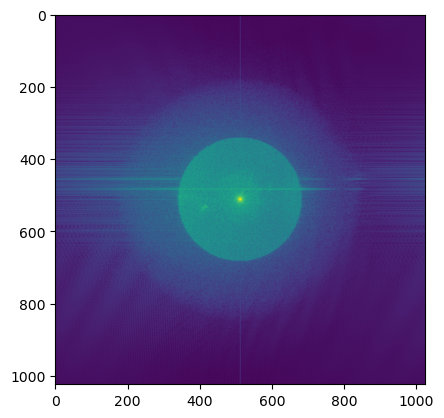

In [41]:
plot_fourier(np.fft.fftshift(np.fft.fft2(retrieved_field[0])))

In [35]:
viewer.add_image(np.angle(retrieved_field))

<Image layer 'Image' at 0x223276771a0>

In [35]:
Us_rytov = np.zeros((Z, N, N), dtype=np.complex128)
for i in tqdm(range(Z)):
    Us_rytov[i] = np.log(retrieved_field[i]/retrieved_background[i])

100%|██████████| 50/50 [00:01<00:00, 40.55it/s]


In [38]:
viewer.add_image(np.angle(Us_born))

<Image layer 'Image' at 0x1e11c6879b0>

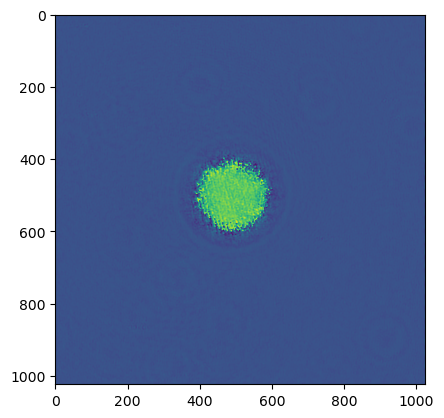

In [31]:
plt.imshow(np.angle(Us_rytov[0]))

<h1> 2. Applying the Fourier diffraction Theorem </h3>

In [84]:
phase = np.zeros((Z, N, N))
amplitude = np.zeros((Z, N, N))

for i in tqdm(range(Z)):
    phase[i] = restoration.unwrap_phase(np.angle(retrieved_field[i]))
    amplitude[i] = np.abs(retrieved_field[i])

100%|██████████| 50/50 [00:14<00:00,  3.54it/s]


In [49]:
viewer.add_image(phase)

<Image layer 'phase' at 0x18715962db0>

In [106]:
illumination_y_idx = np.zeros(Z)
illumination_x_idx = np.zeros(Z)
y_0 = 0
x_0 = 0

for i in range(Z):
    F_back = np.fft.fft2(retrieved_background[i])
    # find illumination center
    yx = get_maxindex(F_back)
    # normal illumination
    if i==0:
        y_0 = yx[0]
        x_0 = yx[1]
    
    # obliqueness
    illumination_y_idx[i] = y_0-yx[1]
    illumination_x_idx[i] = x_0-yx[0]

In [128]:
n_medium = 1.33
v0_nm = (1/lam) * n_medium

v0_x = dv * np.array(illumination_x_idx)
v0_y = dv * np.array(illumination_y_idx)
v0_z = np.real(np.sqrt(v0_nm**2 - v0_x**2 - v0_y**2))

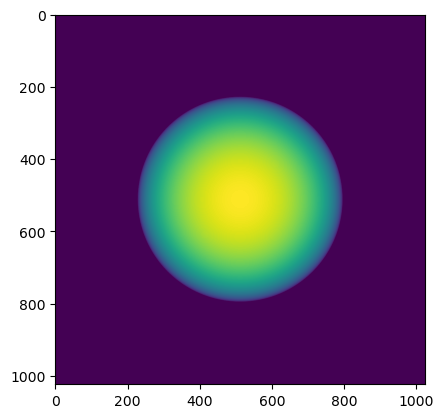

In [129]:
fourier_x = np.arange(-N//2, N//2) * dv
fourier_y = np.arange(-N//2, N//2) * dv
fourier_z = np.arange(-height//2, height//2) * dv

Fourier_X, Fourier_Y = np.meshgrid(fourier_x, fourier_y)
Fourier_Z = np.sqrt(Fourier_X**2 + Fourier_Y**2)

fourier_y = fourier_y[:, None]

v3 = v0_nm**2 - Fourier_Z**2
v3[v3<0] = 0
v3 = np.sqrt(v3)
plt.imshow(v3)

In [132]:
mask = Fourier_Z.copy()
mask[mask > 2*NA/lam] = 0
mask = mask.astype(bool)

rytov = np.zeros((N, N, height), dtype=np.complex128)
count = np.zeros((N, N, height))

In [133]:
filter = circular_filter((N, N), pixel_radius=int(v_optical/dv/2))

for i in tqdm(range(Z)):
    F_rytov = np.log(amplitude[i]) + 1j*phase[i]
    Us_rytov = np.fft.fftshift(np.fft.fft2(F_rytov)) * dx * dx
    Us_rytov = np.roll(Us_rytov, int(v0_y[i]/dv), axis=0)
    Us_rytov = np.roll(Us_rytov, int(v0_x[i]/dv), axis=1)
    Us_rytov = Us_rytov * filter
        
    size_check = np.zeros((N, N))
    vz = v3 + size_check
    vx = fourier_x + size_check
    vy = fourier_y + size_check
        
    Kx = vx - v0_x[i]
    Ky = vy - v0_y[i]
    Kz = vz - v0_z[i]
        
    Uprime = (vz/1j) * Us_rytov

    xind = np.where(
            ((vz > 0) * filter.astype(bool)) &
            (Kx > (dv * (-np.floor(N / 2)))) &
            (Ky > (dv * (-np.floor(N / 2)))) &
            (Kz > (dv_z * (-np.floor(height / 2)))) &
            (Kx < (dv * (np.floor(N / 2) - 1))) &
            (Ky < (dv * (np.floor(N / 2) - 1))) &
            (Kz < (dv_z * (np.floor(height / 2) - 1)))
        )
    xind = np.ravel_multi_index((xind[0], xind[1]), Uprime.shape)

    # 이 밑에가 ewald sphere 만드는부분
    Uprime = Uprime.flat[xind]
    Kx = Kx.flat[xind]
    Ky = Ky.flat[xind]
    Kz = Kz.flat[xind]

    Kx = np.round(Kx / dv + np.floor(N / 2) + 1).astype(int)
    Ky = np.round(Ky / dv + np.floor(N / 2) + 1).astype(int)
    Kz = np.round(Kz / dv_z + np.floor(height / 2) + 1).astype(int)

    Kzp = np.ravel_multi_index((Ky, Kx, Kz), count.shape)
        
    temp = rytov.flat[Kzp]
    rytov.flat[Kzp] = temp + Uprime
    count.flat[Kzp] += (Uprime != 0)

# Final computation and normalization
rytov[count > 0] = rytov[count > 0] / count[count > 0] / np.prod(np.array([dv, dv, dv_z]))

100%|██████████| 50/50 [00:06<00:00,  7.76it/s]


In [134]:
viewer.add_image(np.abs(rytov))

<Image layer 'Image [2]' at 0x1870ce97d40>

In [135]:
rytov_ifftn = np.fft.ifftn(rytov)
potential = rytov_ifftn * 4 * np.pi
k0 = 1/lam
k = 2 * np.pi * n_medium * k0
ri = n_medium * np.sqrt(1+potential/k**2)

# viewer.add_image(np.real(ri))

In [136]:
viewer.add_image(np.abs(rytov_ifftn))

<Image layer 'Image [3]' at 0x1870cfce0c0>

In [99]:
potential.max()

(2.2498334794762858e-21+1.3730350525015788e-22j)

In [96]:
viewer.add_image(np.real(ri))

<Image layer 'Image [2]' at 0x187084fe6f0>

\begin{gather*}

\lambda = 532 nm \\
\nu_{optical} = \frac{NA}{\lambda} \\
\delta x \equiv \frac{\lambda}{NA} = 110nm \sim 100nm = 0.1 \mu m \\
\Delta x = N * \delta x \\
\delta \nu = \frac{1}{\Delta x}

\end{gather*}

\begin{gather*}
x \in \delta x * (-\frac{N}{2}, +\frac{N}{2}) \\
y \in \delta y * (-\frac{N}{2}, +\frac{N}{2}) \\

\\

\nu_x \in \delta \nu_x * (-\frac{N}{2}, +\frac{N}{2}) \\
\nu_y \in \delta \nu_y * (-\frac{N}{2}, +\frac{N}{2}) \\
\nu_z \equiv \sqrt{\nu^2 - \nu_x^2 - \nu_y^2}
\end{gather*}

1. Fourier diffraction theorem 

$$
\hat{U}^{(s)}_{1B}(\vec{k}) = - \frac{1}{i \lambda s_z} \hat{F}(\vec{K})
$$

2. To get a scattered 1st Born approximation field, we first need to calculate an illumination beam at object lens plane
$$
U^{(i)}(x,y;0) = e^{i k \vec{s_0} \cdot \vec{r}}|_{z=0} = e^{i 2 \pi (\nu _{0x} x + \nu _{0y} y)}
$$

3. Then straightforwardly,
$$
U = U^{(i)} + U^{(s)} \Rightarrow U^{(s)} = U - U^{(i)}